Following https://medium.com/technovators/machine-learning-based-multi-label-text-classification-9a0e17f88bb4

In [1]:
import sys

In [2]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import scipy
import gensim


In [3]:
train_dict = pickle.load(open('../nlp_project/train.pkl', 'rb'))
valid_dict = pickle.load(open('../nlp_project/valid.pkl', 'rb'))
test_dict = pickle.load(open('../nlp_project/test.pkl', 'rb'))

In [4]:
# combine valid and test - approx 80/20 split
test_dict = {**valid_dict, **test_dict}

In [5]:
train_dict[list(train_dict.keys())[0]]

{'input': '[Renin-Angiotensin-System (RAS) and COVID-19 - On The Prescription of RAS Blockers]. Twenty years ago, an enzyme homologous to the previously known angiotensin-converting enzyme (ACE) was identified, and subsequently named ACE2. In the renin-angiotensin system (RAS), ACE2 has counter-regulatory functions against the classical effector peptide angiotensin II, for example in blood pressure regulation and cardiovascular remodeling. However, ACE2 provides an initially unexpected interesting link between virology and cardiovascular medicine. That is, ACE2 represents the binding receptor for the cellular uptake of SARS-CoV and SARS-CoV-2 viruses. Thus, ACE2 is relevant for COVID-19. In this context, it was suspected that therapy with RAS blockers might promote transmission and complications of COVID-19 by upregulation of ACE2 expression. The aim of this short review is, to describe the link between the RAS, particularly ACE2, and COVID-19. Based on our analysis and evaluation of t

In [6]:
# Save certain keys only

def load_dict(d:dict):
    
    d_new = {i:{'input': d[i]['input'],
                 'label': d[i]['label'].split(';'),
                 'label_vec': d[i]['label_vec'], 
                 'lemmas': d[i]['lemmas']}
              for i in d
              if len(d[i]['lemmas']) != 0}
    
    return d_new


train_dict = load_dict(train_dict)
# valid_dict = load_dict(valid_dict)
test_dict = load_dict(test_dict)

In [7]:
train_data = pd.DataFrame.from_dict(train_dict, orient='index')
# valid_data = pd.DataFrame.from_dict(valid_dict, orient='index')
test_data = pd.DataFrame.from_dict(test_dict, orient='index')

In [8]:
train_data.head()

,input,label,label_vec,lemmas
PMID:32323279,[Renin-Angiotensin-System (RAS) and COVID-19 -...,"[Treatment, Mechanism]","[0, 0, 0, 0, 1, 0, 0, 1, 0]","[Renin, Angiotensin, System, RAS, covid-19, Pr..."
PMID:32678526,Weaning From Exogenous Sedation in the Era of ...,[Prevention],"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[Weaning, Exogenous, Sedation, Era, COVID-19, ..."
PMID:32302385,"Letter: Rongeurs, Neurosurgeons, and COVID-19:...",[Prevention],"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[letter, Rongeurs, Neurosurgeons, covid-19, pr..."
PMID:32816435,Impact and Mechanism of Covid-19 on Mental Hea...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 1]","[impact, Mechanism, Covid-19, Mental, Health, ..."
PMID:32974671,The implications of vitamin D deficiency on CO...,[Treatment],"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[implication, vitamin, deficiency, covid-19, r..."


In [9]:
comb_df=train_data.append(test_data)

In [10]:
%%time
# Word2Vec the lemmas
train_lemma_l = list(comb_df['lemmas'])
max_lem_vals = max(len(x) for x in train_lemma_l)
print(max_lem_vals)
mean_lem_vals = sum(len(x) for x in train_lemma_l)/len(train_lemma_l)
print(round(mean_lem_vals))

1238
102
CPU times: user 43.6 ms, sys: 240 µs, total: 43.8 ms
Wall time: 43.1 ms


In [11]:
%%time
model = gensim.models.Word2Vec(train_lemma_l,
                 vector_size=max_lem_vals) # picking a vector size higher than the mean lemma counts

CPU times: user 6min 26s, sys: 5.08 s, total: 6min 31s
Wall time: 2min 12s


In [12]:
model.wv.most_similar("vaccine")
# testing out word similarities

[('vaccination', 0.6648397445678711),
 ('cure', 0.5051326155662537),
 ('antiviral', 0.49977269768714905),
 ('countermeasure', 0.49201810359954834),
 ('immunization', 0.47565406560897827),
 ('candidate', 0.4679791331291199),
 ('discovery', 0.463651567697525),
 ('drug', 0.45453348755836487),
 ('eradication', 0.4531054198741913),
 ('BCG', 0.44754302501678467)]

In [13]:
wordvectdict=dict(zip(model.wv.index_to_key,model.wv.vectors))
len(wordvectdict[list(wordvectdict.keys())[0]])

1238

In [14]:
train_data["label_vec"]

PMID:32323279    [0, 0, 0, 0, 1, 0, 0, 1, 0]
PMID:32678526    [0, 0, 0, 0, 0, 1, 0, 0, 0]
PMID:32302385    [0, 0, 0, 0, 0, 1, 0, 0, 0]
PMID:32816435    [0, 0, 0, 0, 0, 0, 0, 0, 1]
PMID:32974671    [0, 0, 0, 0, 0, 0, 0, 1, 0]
                            ...             
PMID:32984792    [0, 0, 0, 0, 0, 0, 0, 1, 0]
PMID:32882706    [0, 0, 0, 0, 1, 0, 0, 1, 0]
PMID:32904944    [0, 0, 0, 0, 1, 0, 0, 1, 0]
PMID:32837019    [0, 0, 0, 0, 0, 0, 0, 0, 1]
PMID:32611659    [1, 0, 0, 0, 0, 0, 0, 0, 0]
Name: label_vec, Length: 52416, dtype: object

In [15]:
%%time
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_data['label'])
test_labels = mlb.transform(test_data['label'])
train_labels[0:10]

CPU times: user 81 ms, sys: 12 ms, total: 93 ms
Wall time: 92.1 ms


array([[0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1]])

In [16]:
class AverageEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim =1238 # because we use the vector size assigned 

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            # if a text is empty we should return a vector of zeros
            # with the same dimensionality as all the other vectors
            for words in X
        ])

In [17]:
# testing_output= np.array([
#             np.mean([wordvectdict[w] for w in words if w in wordvectdict]
#                     or [np.zeros(150)], axis=0)
#             for words in train_data["lemmas"]
#         ])
# testing_output[0:5]

In [18]:
pipe = Pipeline([("wordvect",AverageEmbeddingVectorizer(wordvectdict)),
                ("multilabel",OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

In [19]:
%%time
pipe.fit(train_data['lemmas'],train_labels)

CPU times: user 24.6 s, sys: 2.97 s, total: 27.6 s
Wall time: 4min 17s


Pipeline(steps=[('wordvect',
                 <__main__.AverageEmbeddingVectorizer object at 0x7f1f6b38fa60>),
                ('multilabel',
                 OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1))])

In [20]:
%%time
predicted=pipe.predict(test_data['lemmas'])
svmpredDF = pipe.decision_function(test_data['lemmas'])

CPU times: user 7.59 s, sys: 5.37 s, total: 13 s
Wall time: 6.76 s


In [21]:
pred_f = np.array(predicted)

In [22]:
test_labels[0:5]

array([[0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [23]:
pred_f[0:10]

array([[0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [24]:
with open('map_labels.json', 'r') as f:
    map_labels = json.load(f)

In [25]:
print(metrics.classification_report(test_labels, pred_f, target_names=map_labels.keys()))


                      precision    recall  f1-score   support

         Case Report       0.89      0.55      0.68       773
           Diagnosis       0.90      0.61      0.73       297
Epidemic Forecasting       0.87      0.69      0.77       954
        General Info       0.94      0.59      0.72       104
           Mechanism       1.00      0.06      0.11        18
          Prevention       0.92      0.76      0.83       685
        Transmission       0.84      0.78      0.81      1625
           Treatment       0.77      0.15      0.25       153
                           0.88      0.80      0.84      1347

           micro avg       0.87      0.71      0.78      5956
           macro avg       0.89      0.55      0.64      5956
        weighted avg       0.87      0.71      0.77      5956
         samples avg       0.75      0.72      0.73      5956



/home/max/python/AML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
metrics.roc_auc_score(test_labels, svmpredDF, average=None)

array([0.93453766, 0.98128737, 0.96103343, 0.99595998, 0.97208702,
       0.98264429, 0.94324878, 0.97873768, 0.96500063])

In [27]:
metrics.coverage_error(test_labels, svmpredDF)

1.6086381665932128

In [28]:
confusion_matrix = metrics.multilabel_confusion_matrix(test_labels, pred_f)

Text(0.5, 1.0, 'General Info')

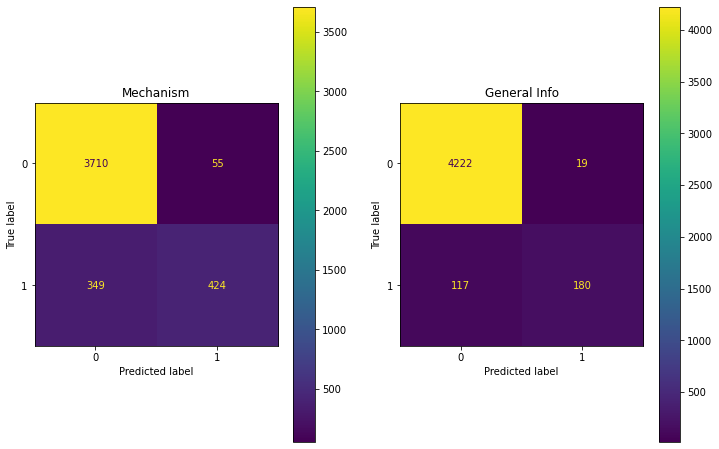

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

disp1 = metrics.ConfusionMatrixDisplay(confusion_matrix[0]).plot(ax=ax1)
disp1.ax_.set_title('Mechanism')

disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix[1]).plot(ax=ax2)
disp2.ax_.set_title('General Info')

In [30]:
accuracy_score(test_labels, pred_f)

0.6337593653591891

In [31]:
f1_score(test_labels, pred_f, average='micro')

0.7823104023734471

In [32]:
precision_score(test_labels, pred_f, average='micro')

0.8734989648033127

In [33]:
recall_score(test_labels, pred_f, average='micro')

0.7083613163196776

/home/max/python/AML/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/max/python/AML/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/max/python/AML/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/max/python/AML/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/max/python/AML/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc